In [178]:
import pandas as pd
import numpy as np
from connect import obtener_conexion
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [179]:
conn = obtener_conexion()

query = """
SELECT 
    c.CustomerID,
    COUNT(o.OrderID) AS TotalOrdenes,
    ROUND(SUM(od.Quantity * od.UnitPrice * (1 - od.Discount)), 2) AS TotalGastado,
    ROUND(AVG(od.Quantity * od.UnitPrice * (1 - od.Discount)), 2) AS PromedioOrden
FROM Customers c
LEFT JOIN Orders o ON c.CustomerID = o.CustomerID
LEFT JOIN [Order Details] od ON o.OrderID = od.OrderID
GROUP BY c.CustomerID
HAVING COUNT(o.OrderID) > 0
ORDER BY TotalGastado DESC;
"""

df = pd.read_sql_query(query, conn)
conn.close()
print(df.head(3))

  CustomerID  TotalOrdenes  TotalGastado  PromedioOrden
0      CHOPS            91     218218.25        2398.00
1      QUICK           129      82489.79         639.46
2      SAVEA           133      76185.77         572.83


C:\Users\lauta\AppData\Local\Temp\ipykernel_7308\3372249161.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


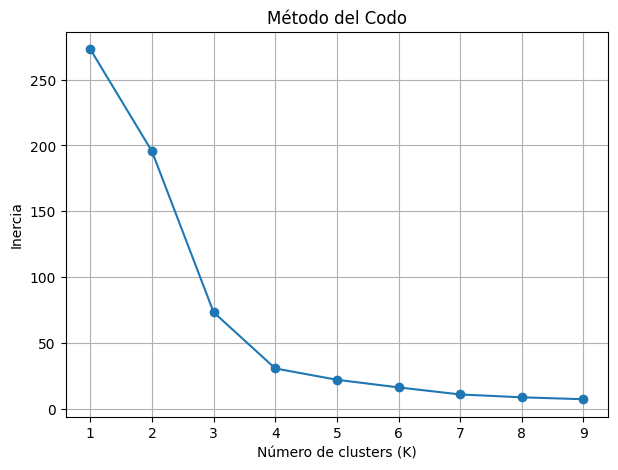

In [180]:
scaler = StandardScaler()
X = scaler.fit_transform(df[['TotalOrdenes', 'TotalGastado', 'PromedioOrden']])

inercia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inercia.append(kmeans.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, inercia, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()


In [181]:
k_final = 3 
kmeans = KMeans(n_clusters=k_final, random_state=42)
df['cluster'] = kmeans.fit_predict(X)
df_clusters = df.copy()


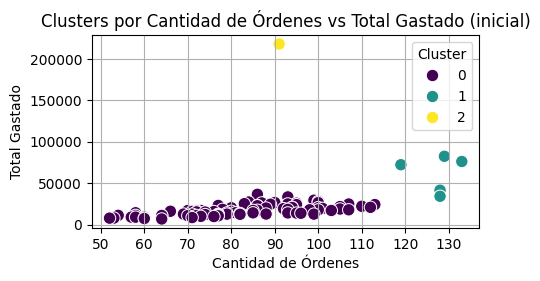

In [182]:

plt.figure(figsize=(5,2.5))
sns.scatterplot(
    data=df_clusters,
    x="TotalOrdenes",
    y="TotalGastado",
    hue="cluster",
    palette="viridis",
    s=80,
    edgecolor='w'
)
plt.title("Clusters por Cantidad de Órdenes vs Total Gastado (inicial)")
plt.xlabel("Cantidad de Órdenes")
plt.ylabel("Total Gastado")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

In [183]:
umbral = df['TotalGastado'].quantile(0.99)
outliers = df[df['TotalGastado'] > umbral]

print("\nOUTLIERS DETECTADOS:")
print(outliers[['CustomerID', 'TotalOrdenes', 'TotalGastado', 'PromedioOrden']])


OUTLIERS DETECTADOS:
  CustomerID  TotalOrdenes  TotalGastado  PromedioOrden
0      CHOPS            91     218218.25         2398.0


In [184]:
df_model = df[df['TotalGastado'] <= umbral].copy()

In [185]:
scaler2 = StandardScaler()
X_model = scaler2.fit_transform(df_model[['TotalOrdenes', 'TotalGastado', 'PromedioOrden']])

In [186]:
kmeans2 = KMeans(n_clusters=3, random_state=42)
df_model['cluster'] = kmeans2.fit_predict(X_model)

In [187]:
kmeans2 = KMeans(n_clusters=3, random_state=42)
df_model['cluster'] = kmeans2.fit_predict(X_model)

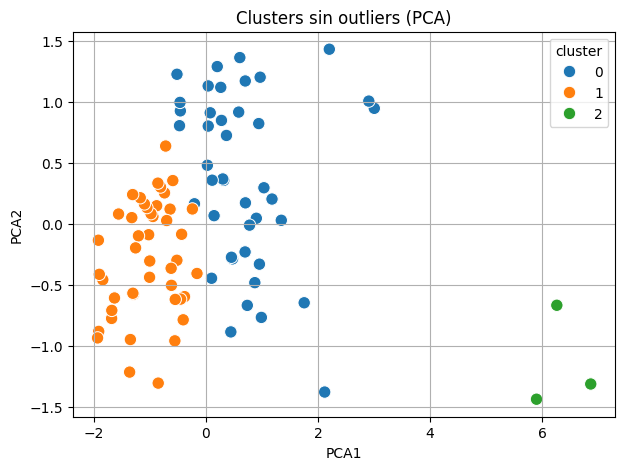

In [188]:
pca2 = PCA(n_components=2)
pca_result2 = pca2.fit_transform(X_model)
df_model['PCA1'] = pca_result2[:, 0]
df_model['PCA2'] = pca_result2[:, 1]
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_model, x='PCA1', y='PCA2', hue='cluster', palette='tab10', s=80, edgecolor='w')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clusters sin outliers (PCA)')
plt.grid(True)
plt.show()

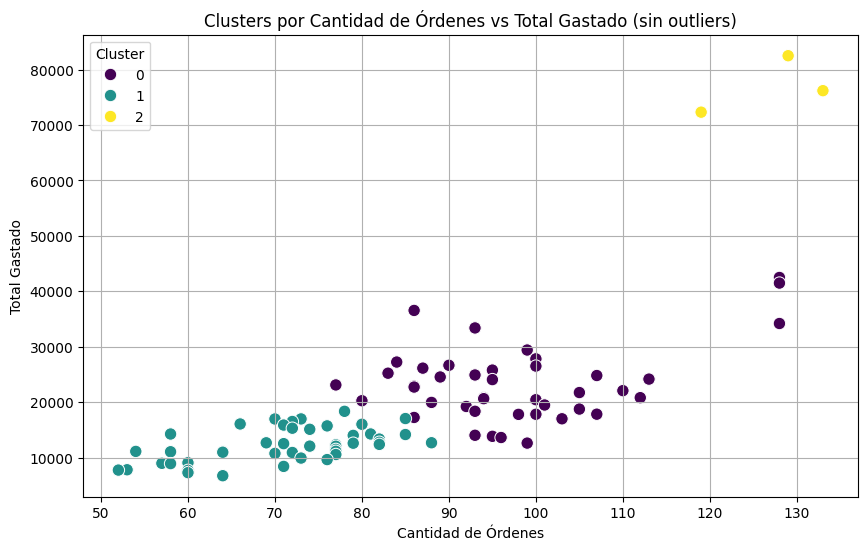

In [189]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_model,
    x="TotalOrdenes",
    y="TotalGastado",
    hue="cluster",
    palette="viridis",
    s=80,
    edgecolor='w'
)
plt.title("Clusters por Cantidad de Órdenes vs Total Gastado (sin outliers)")
plt.xlabel("Cantidad de Órdenes")
plt.ylabel("Total Gastado")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

# =============== OPCIONAL: exportar clusters a CSV ===============
df_clusters.to_csv("clientes_clusters_inicial.csv", index=False, sep=";")
df_model.to_csv("clientes_clusters_sin_outliers.csv", index=False, sep=";")